# 03 - Model Training 

In [1]:
import pandas as pd, numpy as np, os, joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df=pd.read_csv("../data/cleaned_data.csv")
df.head()

,Previous_Score,Hours_Studied,Attendance,Assignments_Completed,Sleep_Hours,Participation,Final_Score,Pass_Fail
0,69.9,1.83,82.6,7,6.0,0,70.6,1
1,50.9,2.55,36.8,4,5.9,0,40.1,1
2,74.4,2.09,60.1,8,9.1,2,58.9,1
3,100.0,2.68,64.4,4,9.8,2,74.9,1
4,48.0,3.18,65.2,8,5.6,2,46.0,1


In [3]:
feature_cols=[
 'Hours_Studied','Attendance','Previous_Score',
 'Assignments_Completed','Sleep_Hours','Participation'
]
max_score=df['Final_Score'].max()
df['Final_Score_Scaled']=(df['Final_Score']/max_score)*100
y_reg=df['Final_Score_Scaled']
y_clf=df['Pass_Fail']
X=df[feature_cols]

In [4]:
X_train_reg,X_test_reg,y_train_reg,y_test_reg=train_test_split(X,y_reg,test_size=0.2,random_state=42)
X_train_clf,X_test_clf,y_train_clf,y_test_clf=train_test_split(X,y_clf,test_size=0.2,random_state=42)

In [5]:
numeric_features=feature_cols
numeric_transformer=Pipeline(steps=[
 ('imputer',SimpleImputer(strategy='median')),
 ('scaler',StandardScaler())
])
preprocessor=ColumnTransformer([('num',numeric_transformer,numeric_features)])

reg_pipe=Pipeline([
 ('prep',preprocessor),
 ('model',RandomForestRegressor())
])

param_grid={
 'model__n_estimators':[100,200],
 'model__max_depth':[None,10,20]
}

grid_rf=GridSearchCV(reg_pipe,param_grid,cv=5,n_jobs=-1)
grid_rf.fit(X_train_reg,y_train_reg)
pipe_best_rf=grid_rf.best_estimator_
print("Best RF Reg params:",grid_rf.best_params_)
pred=pipe_best_rf.predict(X_test_reg)
print("R2:",r2_score(y_test_reg,pred))

os.makedirs("../models",exist_ok=True)
joblib.dump(pipe_best_rf,"../models/best_rf_reg_scaled.pkl")


Best RF Reg params: {'model__max_depth': 20, 'model__n_estimators': 200}
R2: 0.9721620238335469


['../models/best_rf_reg_scaled.pkl']

In [6]:
clf_pipe=Pipeline([
 ('prep',preprocessor),
 ('model',RandomForestClassifier())
])

param_grid_clf={
 'model__n_estimators':[100,200],
 'model__max_depth':[None,10,20]
}

grid_rf_clf=GridSearchCV(clf_pipe,param_grid_clf,cv=5,n_jobs=-1)
grid_rf_clf.fit(X_train_clf,y_train_clf)
pipe_best_rf_clf=grid_rf_clf.best_estimator_
print("Best RF CLF params:",grid_rf_clf.best_params_)
pred_clf=pipe_best_rf_clf.predict(X_test_clf)
print("Accuracy:",accuracy_score(y_test_clf,pred_clf))

joblib.dump(pipe_best_rf_clf,"../models/best_rf_clf_scaled.pkl")

Best RF CLF params: {'model__max_depth': None, 'model__n_estimators': 200}
Accuracy: 0.9583333333333334


['../models/best_rf_clf_scaled.pkl']


==== REGRESSION METRICS ====
MAE  : 2.2563
RMSE : 2.8477
R²   : 0.9722


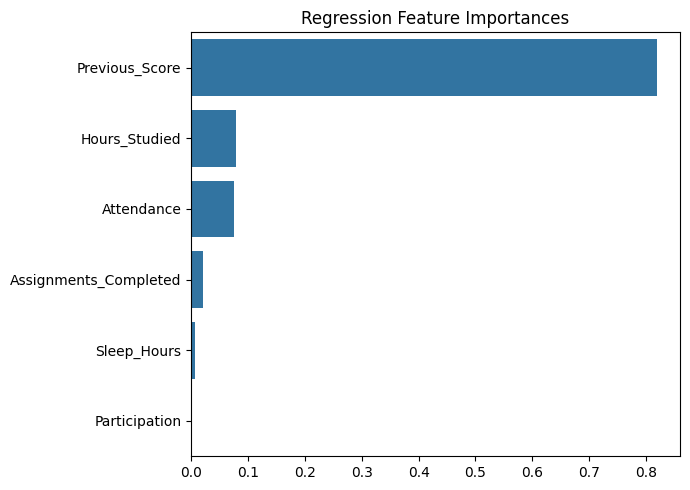


==== CLASSIFICATION METRICS ====
Accuracy : 0.9583
Precision: 0.9698
Recall   : 0.9761
F1 Score : 0.9730

Confusion Matrix:
 [[250  28]
 [ 22 900]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       278
           1       0.97      0.98      0.97       922

    accuracy                           0.96      1200
   macro avg       0.94      0.94      0.94      1200
weighted avg       0.96      0.96      0.96      1200



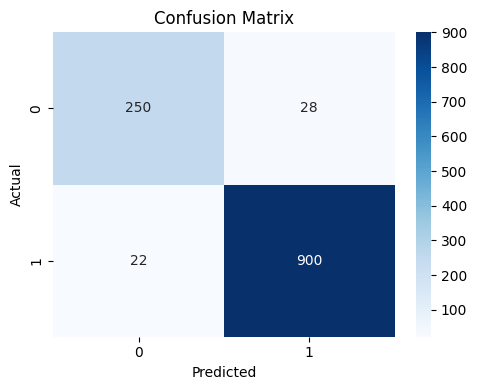

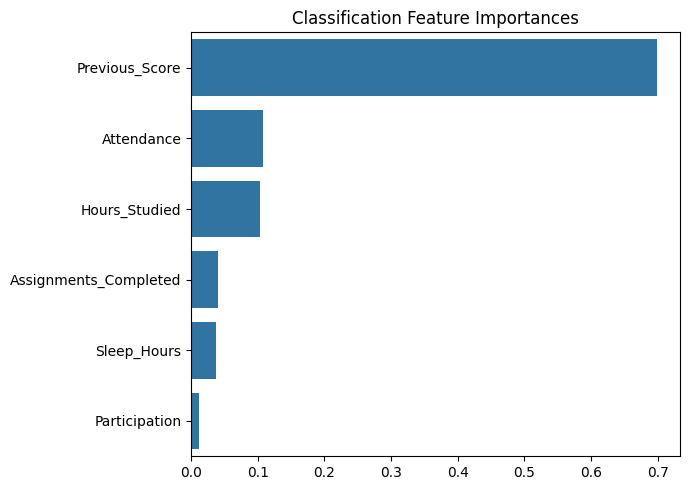


All models saved successfully in ../models/

All metrics saved successfully in ../reports/

All plots saved successfully in ../reports/


In [7]:

import json, numpy as np, joblib, os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

os.makedirs("../models", exist_ok=True)

# 1️⃣ REGRESSION EVALUATION

reg_pred = pipe_best_rf.predict(X_test_reg)

MAE  = mean_absolute_error(y_test_reg, reg_pred)
MSE  = mean_squared_error(y_test_reg, reg_pred)
RMSE = np.sqrt(MSE)
R2   = r2_score(y_test_reg, reg_pred)

print("\n==== REGRESSION METRICS ====")
print(f"MAE  : {MAE:.4f}")
print(f"RMSE : {RMSE:.4f}")
print(f"R²   : {R2:.4f}")

# Save metrics
reg_metrics = {"MAE": float(MAE), "RMSE": float(RMSE), "R2": float(R2)}
with open("../reports/regression_metrics.json", "w") as f:
    json.dump(reg_metrics, f, indent=2)

# Feature Importances (Regression)
try:
    reg_importances = pipe_best_rf.named_steps["model"].feature_importances_
    idx = np.argsort(reg_importances)[::-1]

    plt.figure(figsize=(7,5))
    sns.barplot(x=reg_importances[idx], y=np.array(numeric_features)[idx])
    plt.title("Regression Feature Importances")
    plt.tight_layout()
    plt.savefig("../reports/reg_feature_importances.png", dpi=150)
    plt.show()
except:
    print("Regression feature importances not available.")


# 2️⃣ CLASSIFICATION EVALUATION

clf_pred = pipe_best_rf_clf.predict(X_test_clf)

ACC = accuracy_score(y_test_clf, clf_pred)
PREC = precision_score(y_test_clf, clf_pred, average="binary", zero_division=0)
REC  = recall_score(y_test_clf, clf_pred, average="binary", zero_division=0)
F1   = f1_score(y_test_clf, clf_pred, average="binary", zero_division=0)
CM   = confusion_matrix(y_test_clf, clf_pred)

print("\n==== CLASSIFICATION METRICS ====")
print(f"Accuracy : {ACC:.4f}")
print(f"Precision: {PREC:.4f}")
print(f"Recall   : {REC:.4f}")
print(f"F1 Score : {F1:.4f}")
print("\nConfusion Matrix:\n", CM)
print("\nClassification Report:\n", classification_report(y_test_clf, clf_pred, zero_division=0))

# Save classification metrics
clf_metrics = {
    "Accuracy": float(ACC),
    "Precision": float(PREC),
    "Recall": float(REC),
    "F1": float(F1),
    "Confusion_Matrix": CM.tolist()
}
with open("../reports/classification_metrics.json", "w") as f:
    json.dump(clf_metrics, f, indent=2)

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
sns.heatmap(CM, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("../reports/confusion_matrix.png", dpi=150)
plt.show()

# Feature Importances (Classification)
try:
    clf_importances = pipe_best_rf_clf.named_steps["model"].feature_importances_
    idx = np.argsort(clf_importances)[::-1]

    plt.figure(figsize=(7,5))
    sns.barplot(x=clf_importances[idx], y=np.array(numeric_features)[idx])
    plt.title("Classification Feature Importances")
    plt.tight_layout()
    plt.savefig("../reports/clf_feature_importances.png", dpi=150)
    plt.show()
except:
    print("Classification feature importances not available.")


# 3️⃣ SAVE TRAINED MODELS

joblib.dump(pipe_best_rf, "../models/best_rf_reg_scaled.pkl")
joblib.dump(pipe_best_rf_clf, "../models/best_rf_clf_scaled.pkl")

print("\nAll models saved successfully in ../models/")
print("\nAll metrics saved successfully in ../reports/")
print("\nAll plots saved successfully in ../reports/")  
